In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
from pybedtools import Interval

In [40]:
from bpnet.preproc import resize_interval

In [43]:
from copy import deepcopy

In [44]:
from genomelake.extractors import BigwigExtractor

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
from scipy.stats import skew

In [47]:
import numpy as np
# Function to normalize specific column in a minibatch
def normalize(row):
    mean = np.mean(row, axis=0)
    var = np.var(row, axis=0)
    row = np.subtract(row, mean)
    return np.divide(row, np.sqrt(var) + 1e-6)

In [48]:
def get_substr(string):
    return string[string.rindex('/')+1:]

In [60]:
intervals = input("Please enter chr, start, end, chr2, start2, end2, chr3, start3, end3, etc")
intervals = intervals.split()
intervals

Please enter chr, start, end, chr2, start2, end2, chr3, start3, end3, etcchr1	10208878	10212009	 chr1	109477442	109478453	 chr1	225956988	225965856	 chr1	75769458	75772146	 chr1	45231468	45233580	 chr1	114082846	114084069	 chr1	223128926	223136857	


['chr1',
 '10208878',
 '10212009',
 'chr1',
 '109477442',
 '109478453',
 'chr1',
 '225956988',
 '225965856',
 'chr1',
 '75769458',
 '75772146',
 'chr1',
 '45231468',
 '45233580',
 'chr1',
 '114082846',
 '114084069',
 'chr1',
 '223128926',
 '223136857']

In [61]:
files = ['/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/Methyl.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/NT2_RNAseq_rep1.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/NT2_RNAseq_rep2.bw',
                                            '/share/quonlab/workspaces/ricsharma/data/bpp_100_f.bw',
                                            '/share/quonlab/workspaces/ricsharma/data/bpp_100_r.bw',
                                            '/share/quonlab/workspaces/ricsharma/data/bpp_250_f.bw',
                                            '/share/quonlab/workspaces/ricsharma/data/bpp_250_r.bw',
                                            '/share/quonlab/workspaces/ricsharma/data/bpp_500_f.bw',
                                            '/share/quonlab/workspaces/ricsharma/data/bpp_500_r.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/100_neg_gc_skew.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/25_neg_purine_skew.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/gc_content_25.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/gc_skew_50.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/100_neg_purine_skew.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/50_neg_gc_skew.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/gc_content_50.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/GeneAnnotations_neg.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/purine_skew_100.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/250_neg_gc_skew.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/50_neg_purine_skew.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/gc_skew_100.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/GeneAnnotations_pos.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/purine_skew_250.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/250_neg_purine_skew.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/gc_content_100.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/gc_skew_250.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/purine_skew_25.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/25_neg_gc_skew.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/gc_content_250.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/gc_skew_25.bw',
                                            '/share/quonlab/workspaces/ricsharma/all_tracks/bigwig/purine_skew_50.bw']

In [62]:
def make_plots(rows, low=None, high=None, title=None): 
    for ind in range(len(rows)):
        normalized_col = normalize(rows[ind])
        _, ax = plt.subplots()
        if low is not None and high is not None:
            ax.set_xlim(low, high)
            ax.set_xticks(range(low, high))
        
        row_skew = skew(rows[ind])
        set_title = "Computed Skew Score: " + str(row_skew)
        if title is not None:
            set_title = title
        
        sns.distplot(normalized_col, axlabel=get_substr(files[ind]), ax=ax).set(title=set_title)

chr1:10208878,10212009
chr1:109477442,109478453
chr1:225956988,225965856
chr1:75769458,75772146
chr1:45231468,45233580
chr1:114082846,114084069
chr1:223128926,223136857


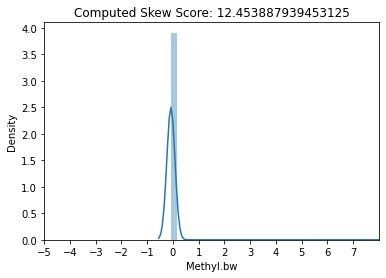

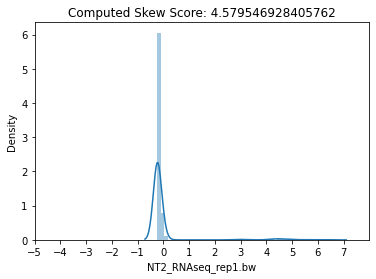

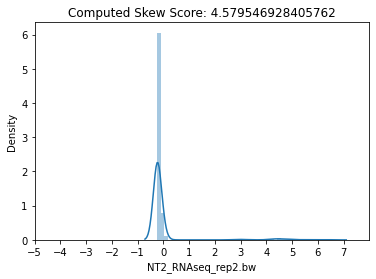

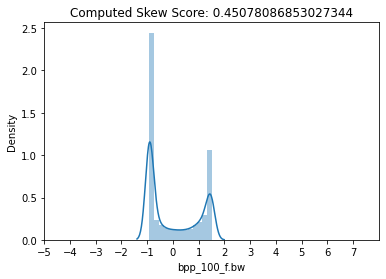

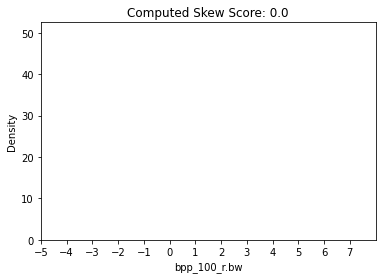

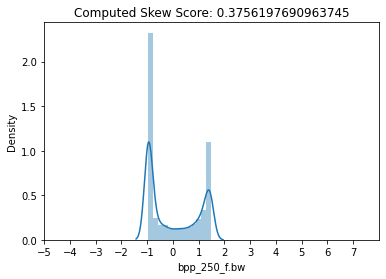

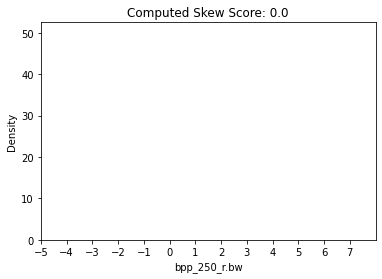

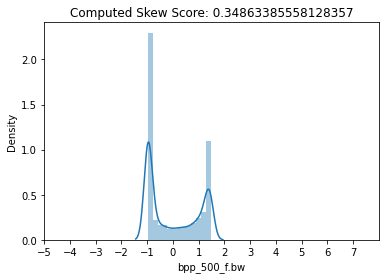

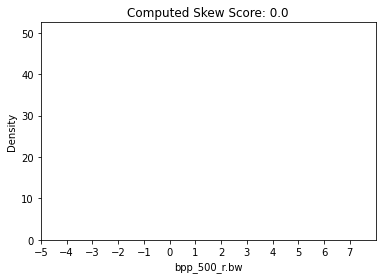

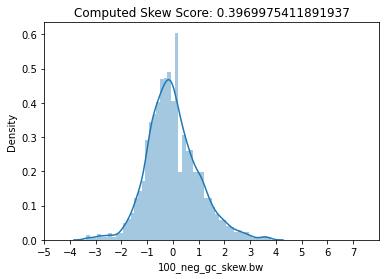

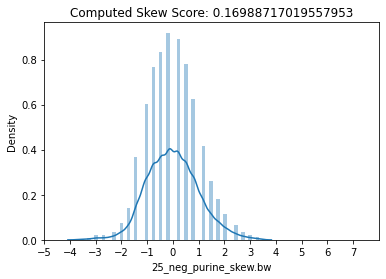

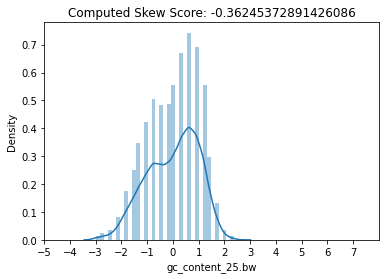

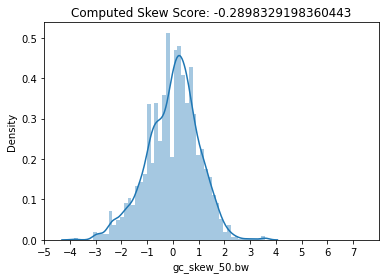

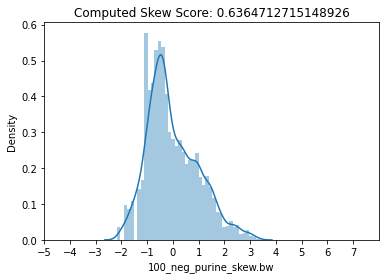

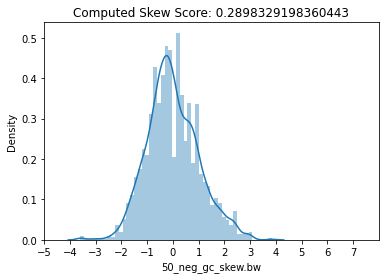

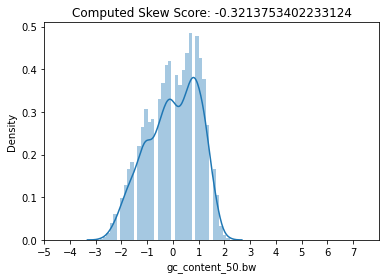

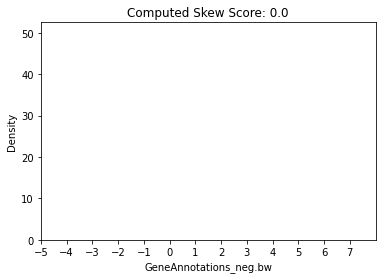

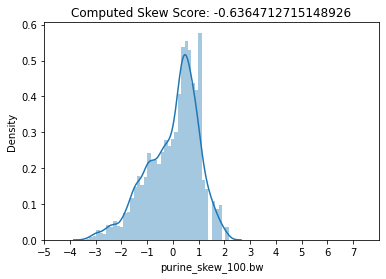

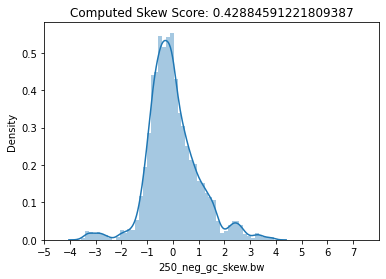

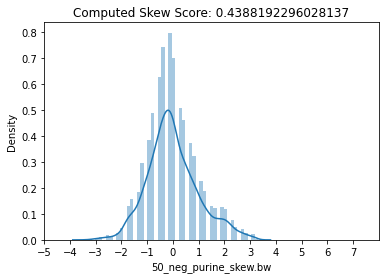

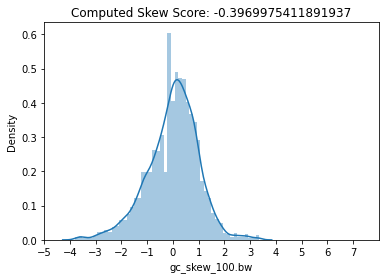

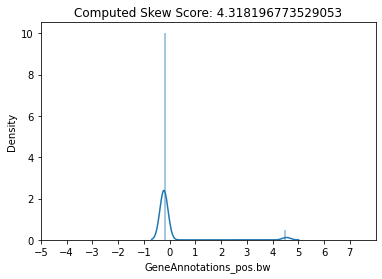

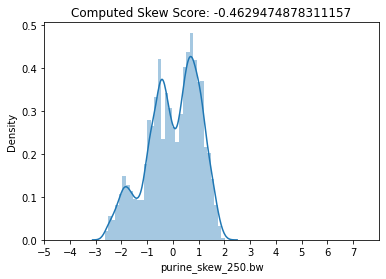

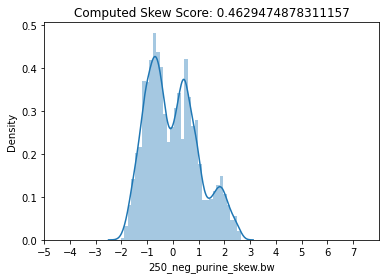

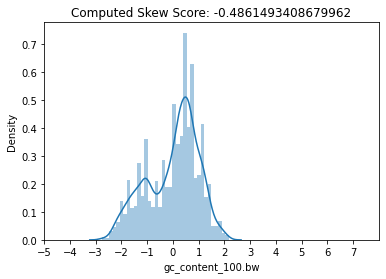

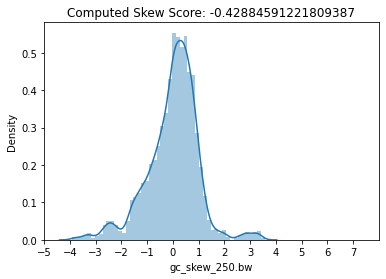

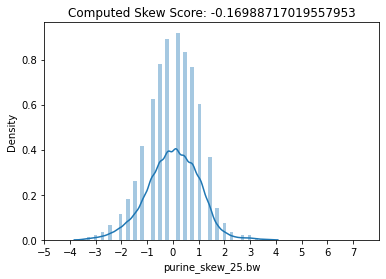

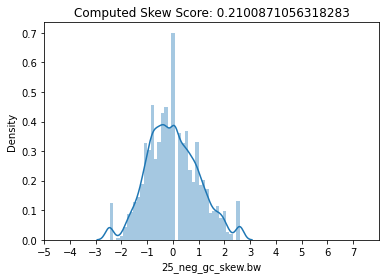

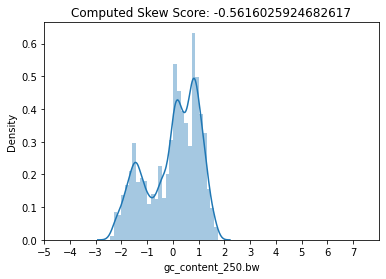

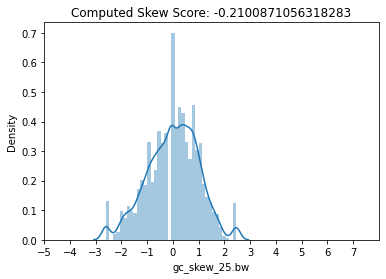

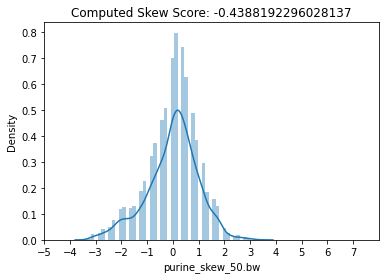

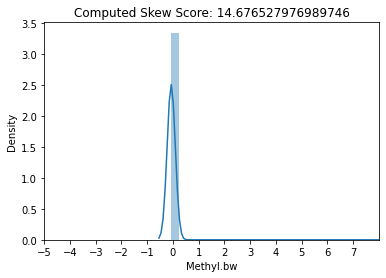

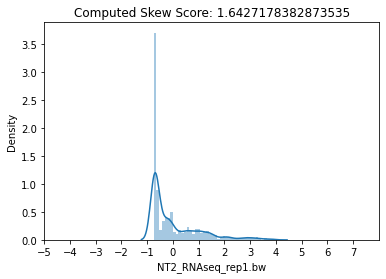

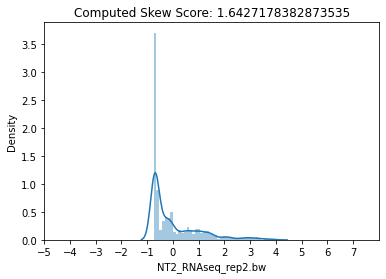

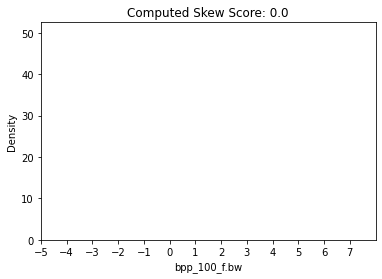

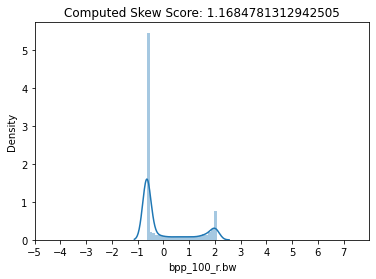

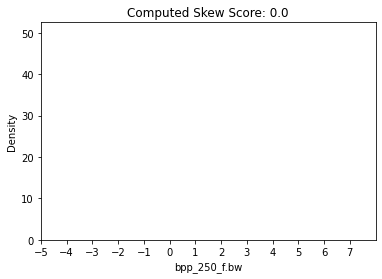

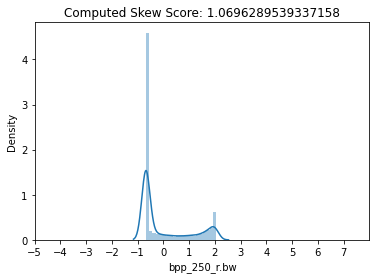

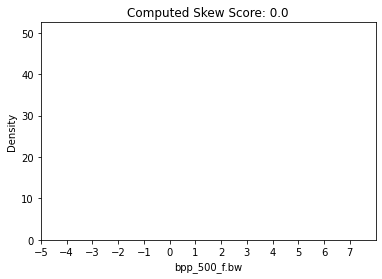

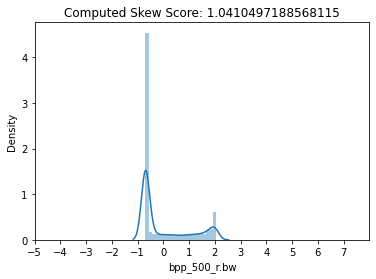

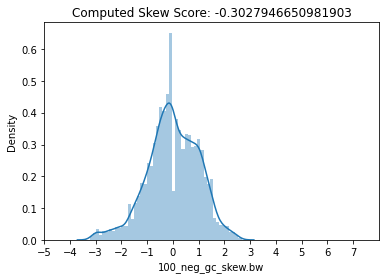

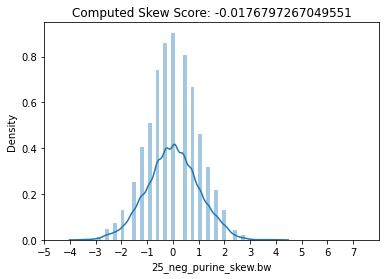

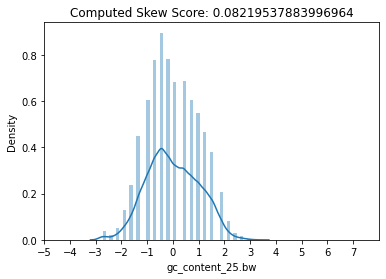

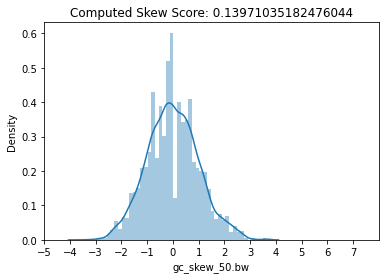

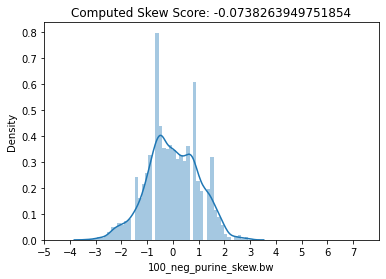

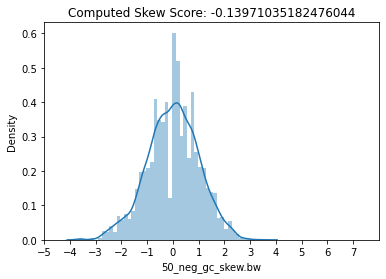

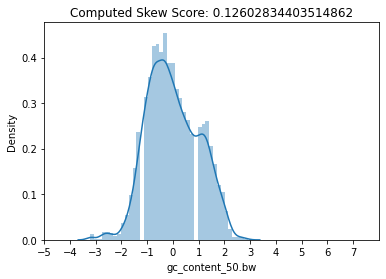

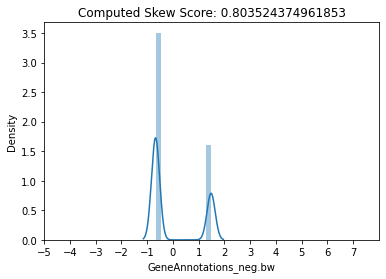

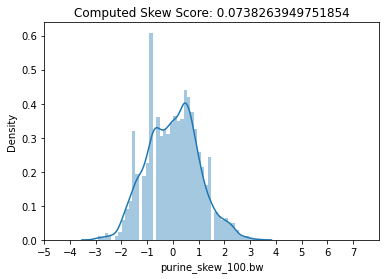

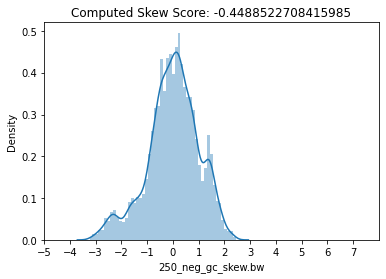

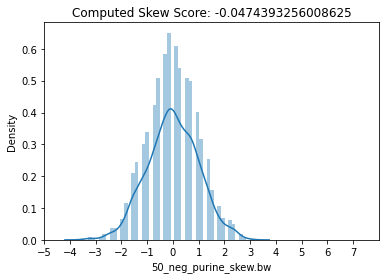

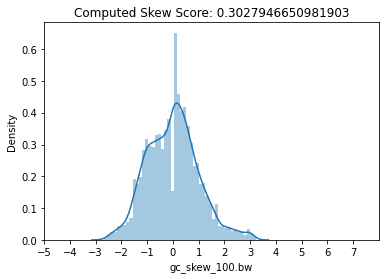

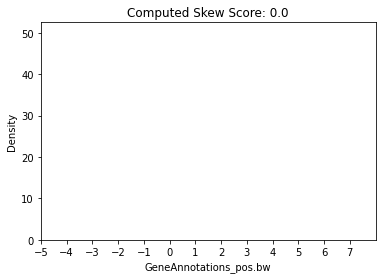

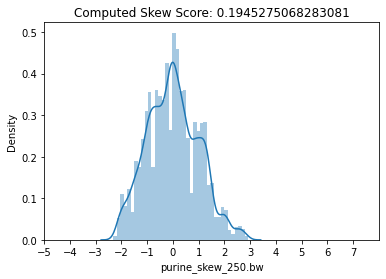

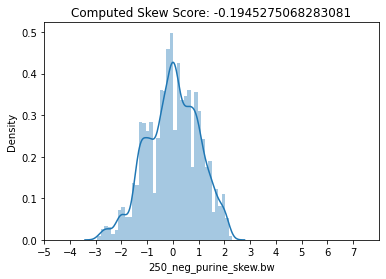

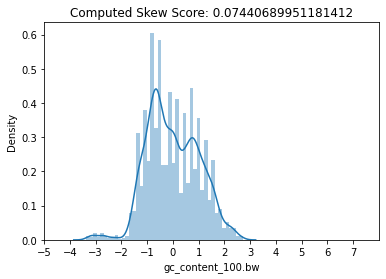

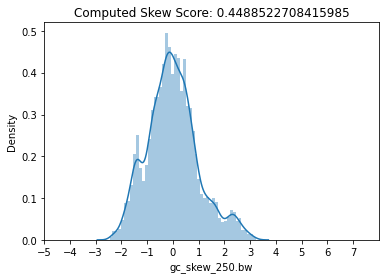

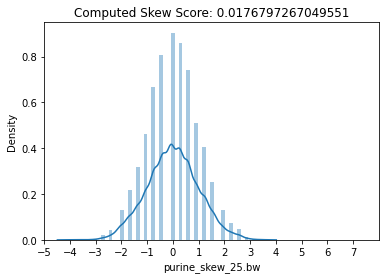

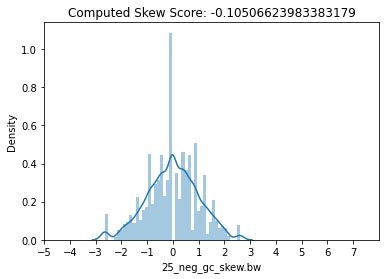

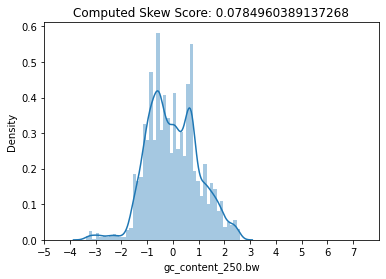

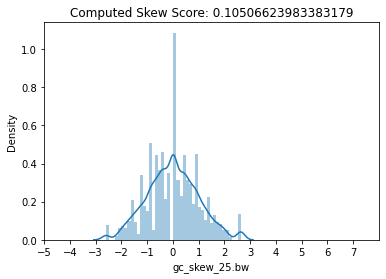

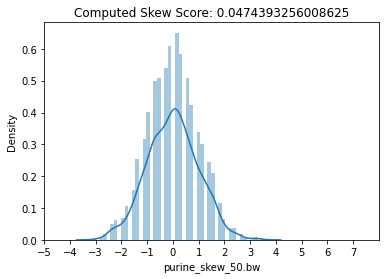

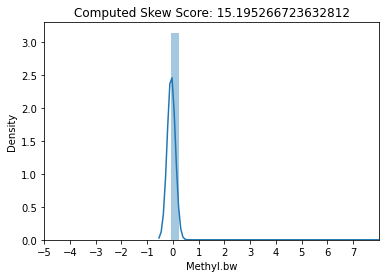

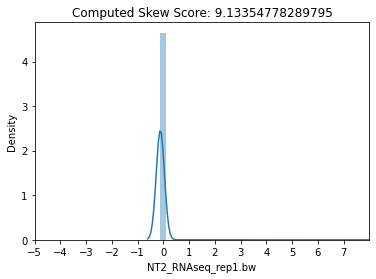

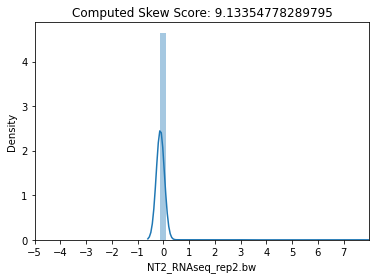

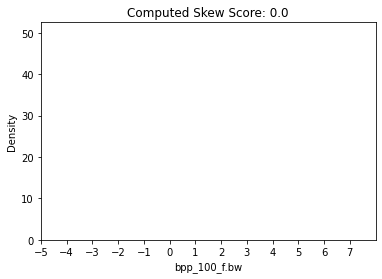

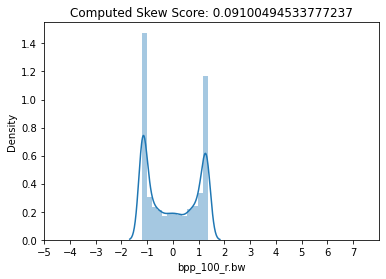

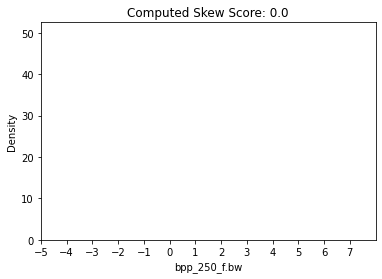

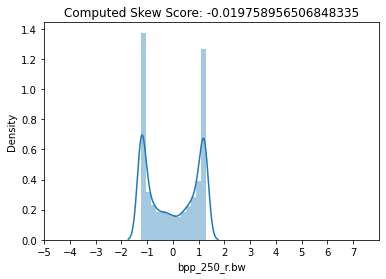

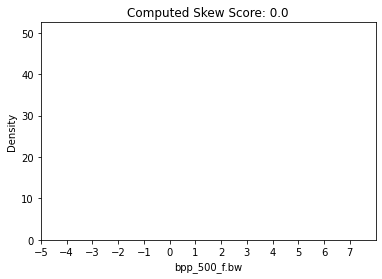

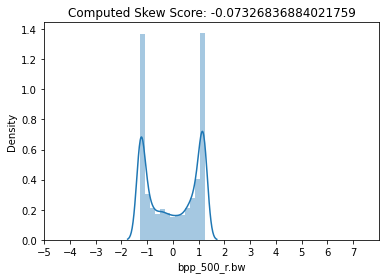

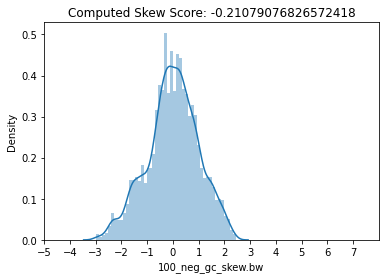

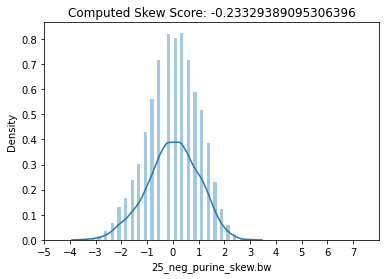

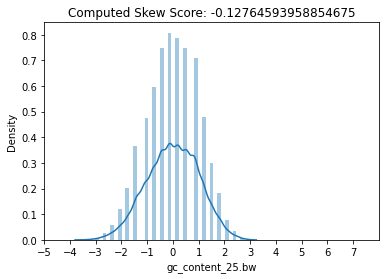

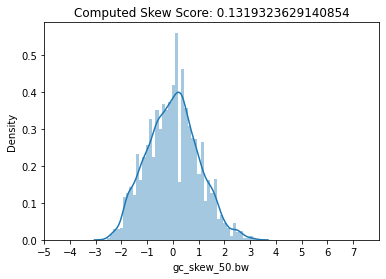

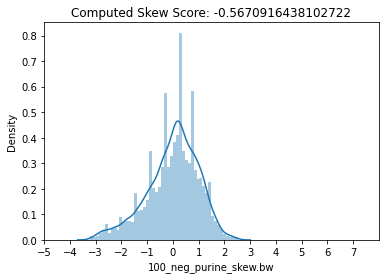

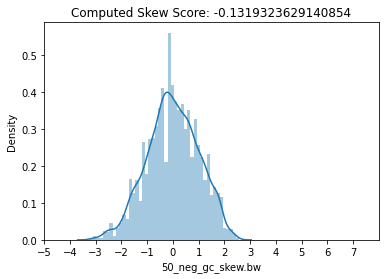

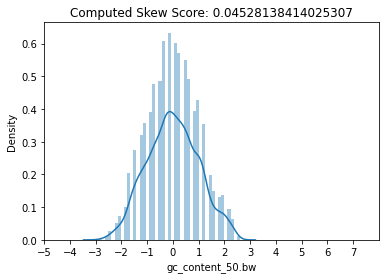

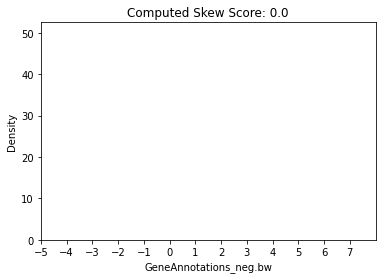

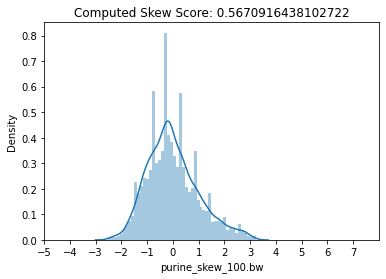

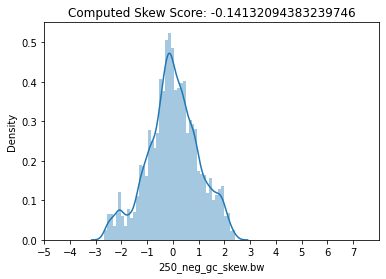

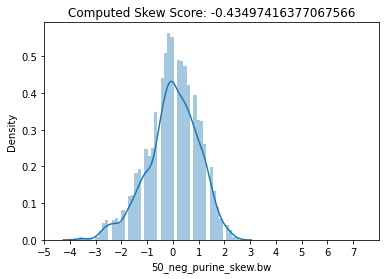

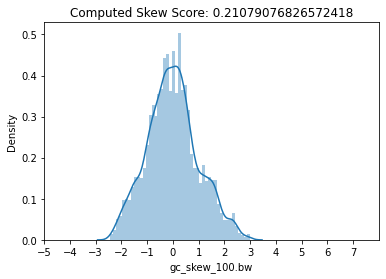

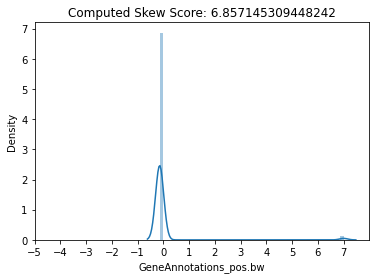

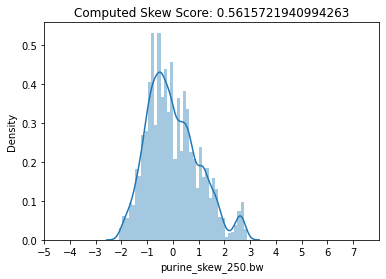

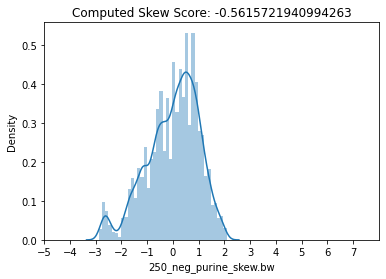

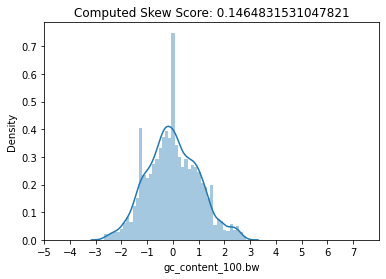

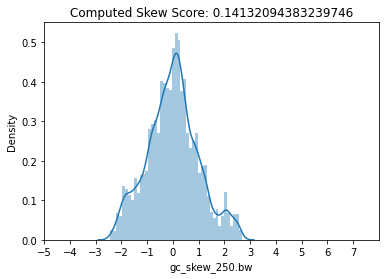

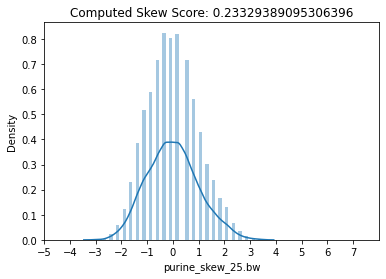

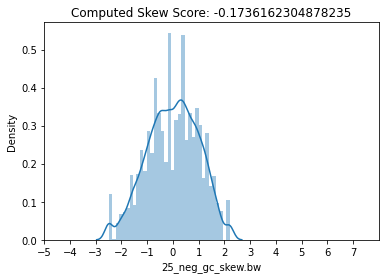

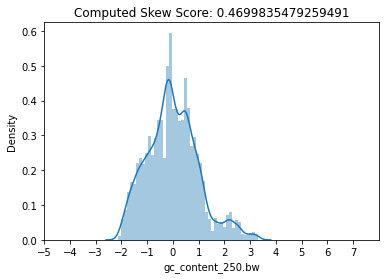

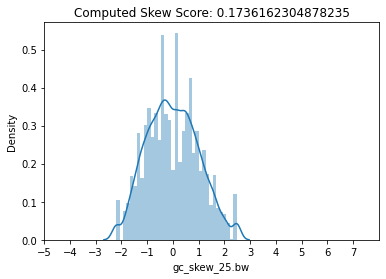

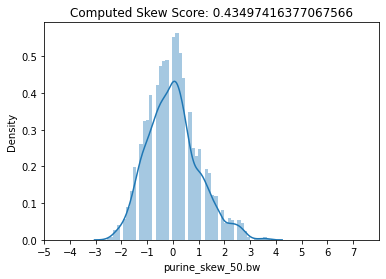

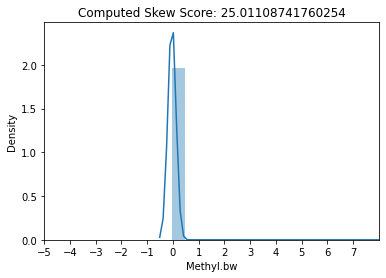

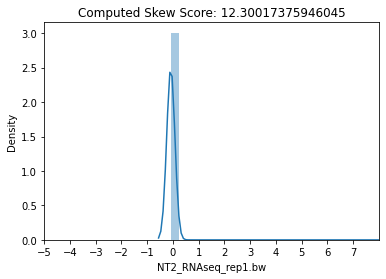

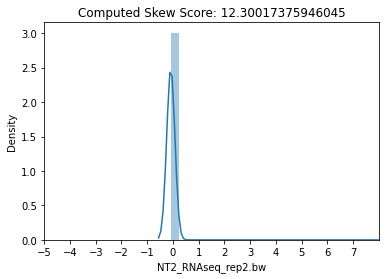

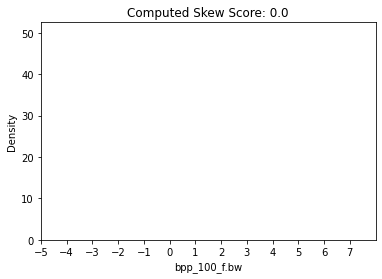

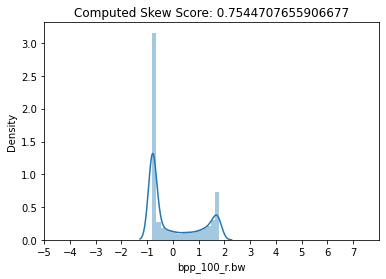

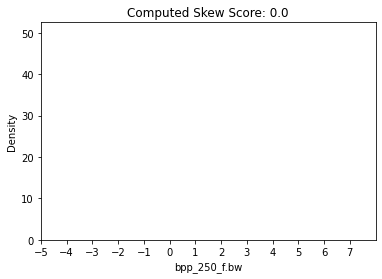

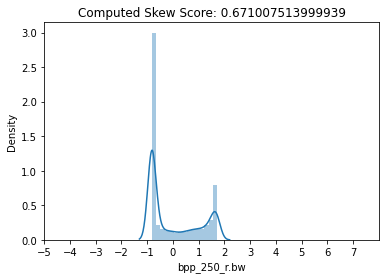

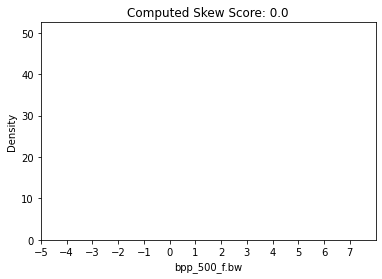

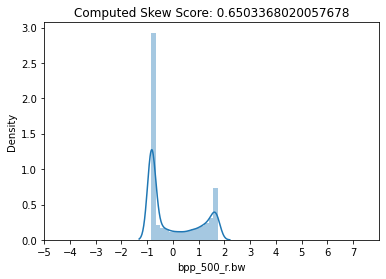

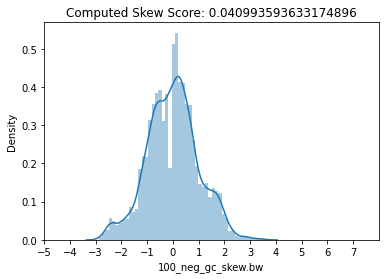

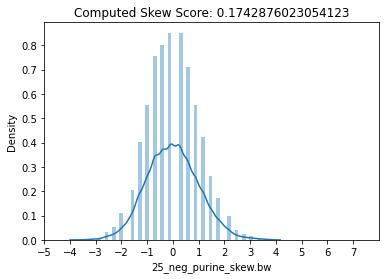

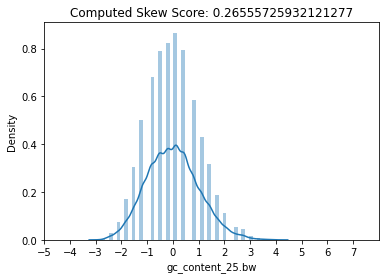

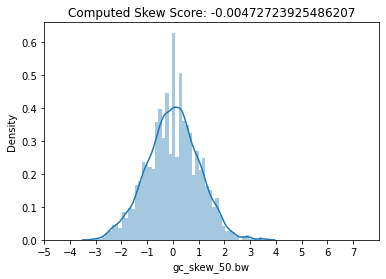

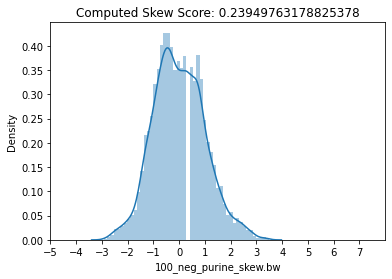

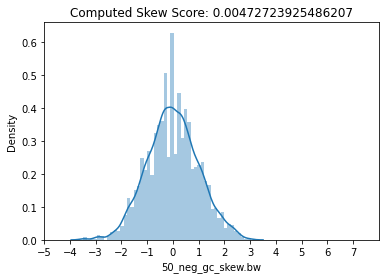

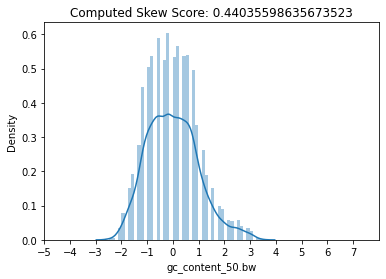

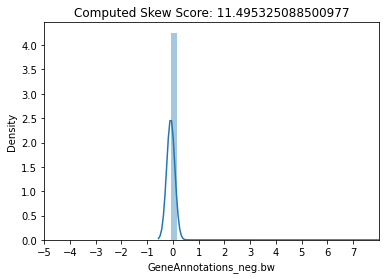

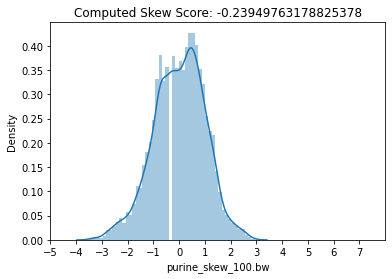

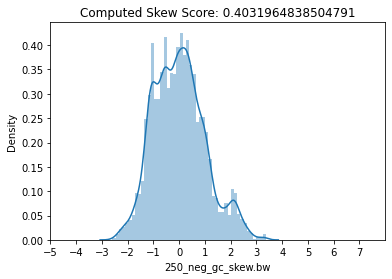

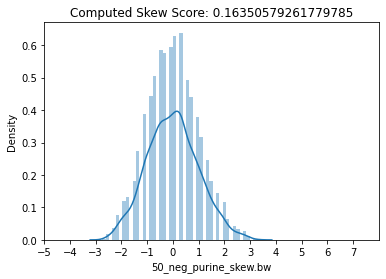

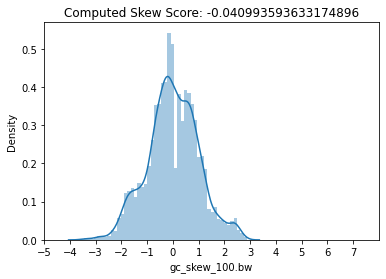

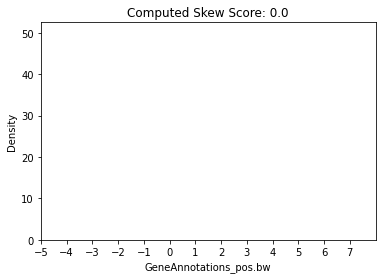

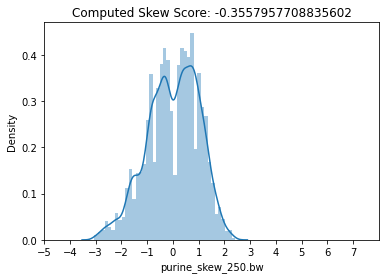

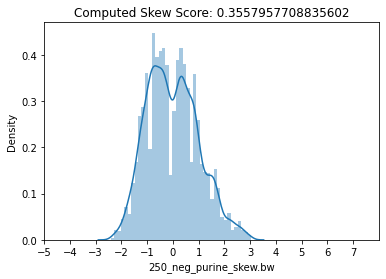

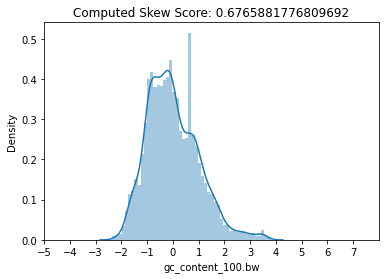

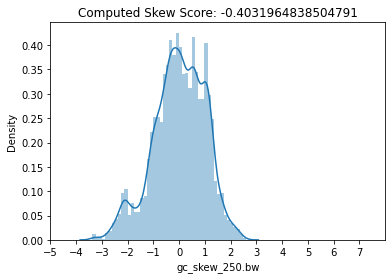

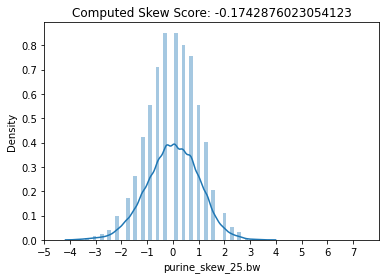

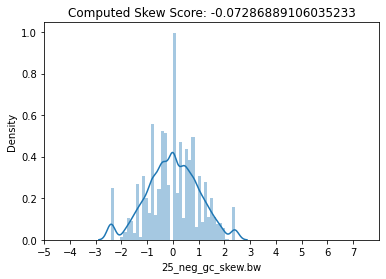

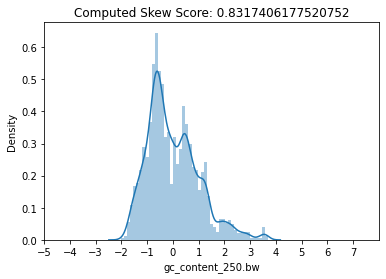

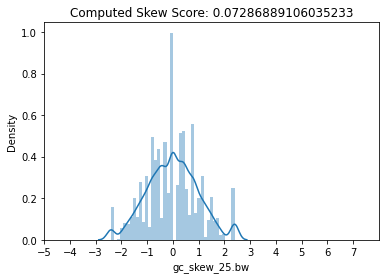

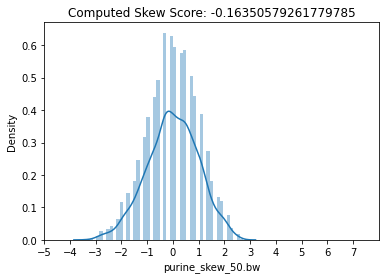

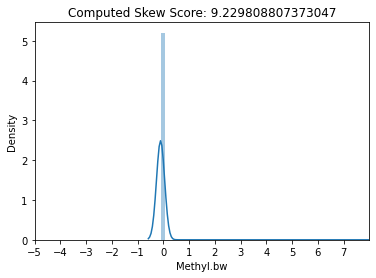

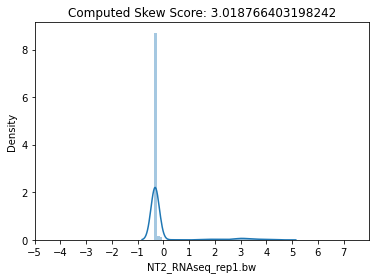

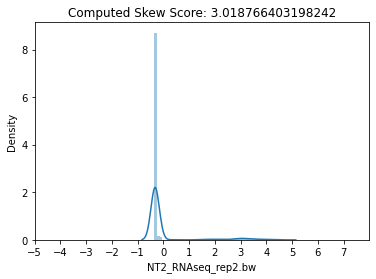

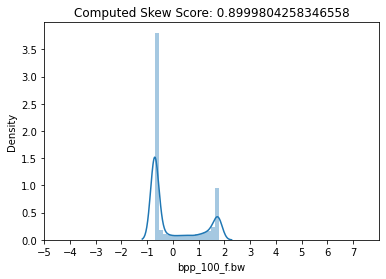

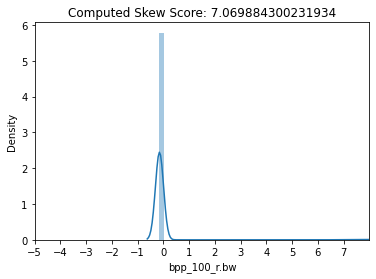

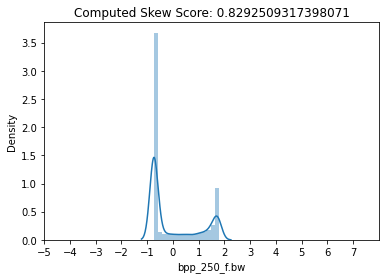

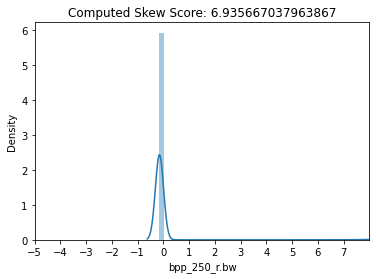

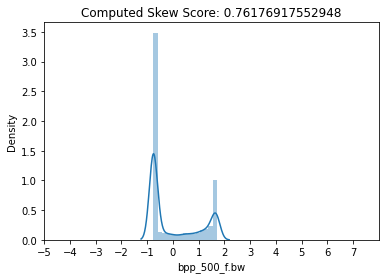

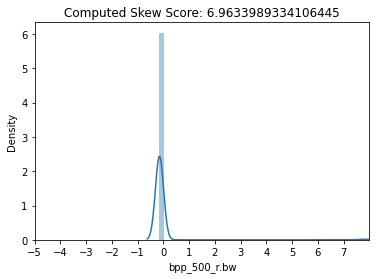

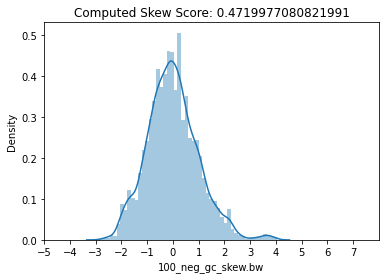

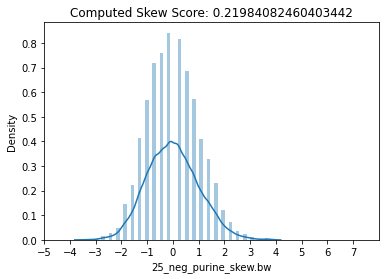

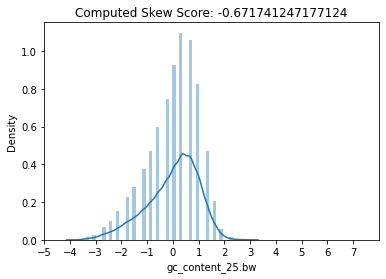

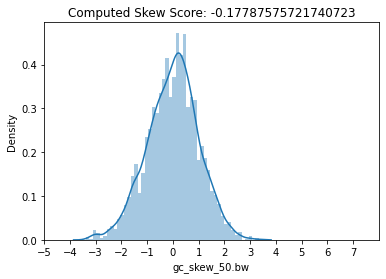

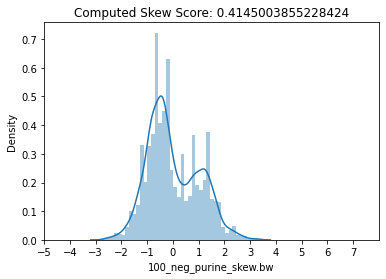

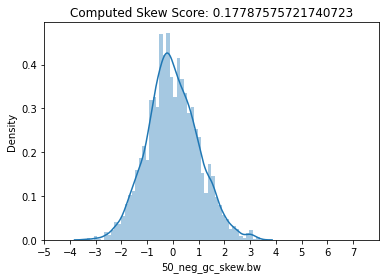

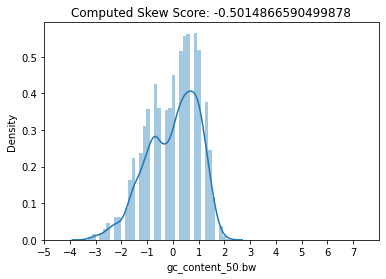

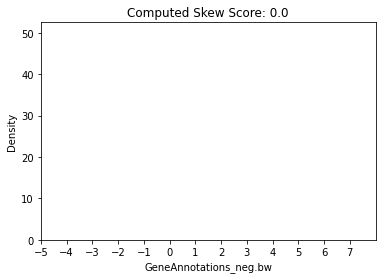

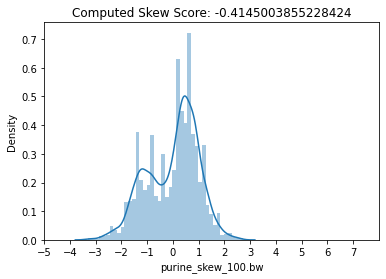

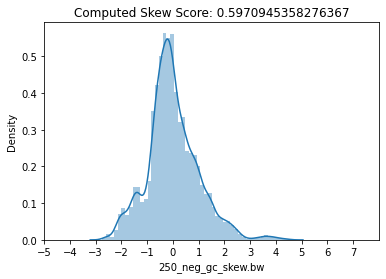

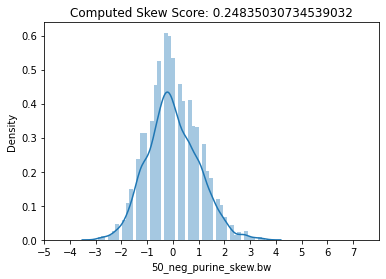

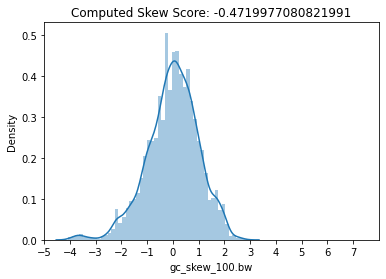

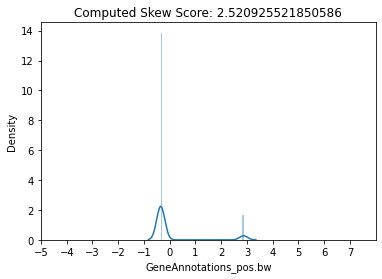

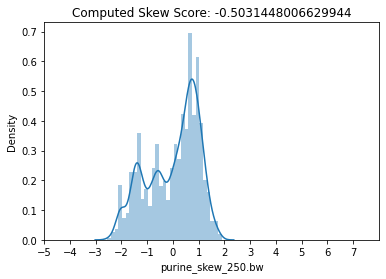

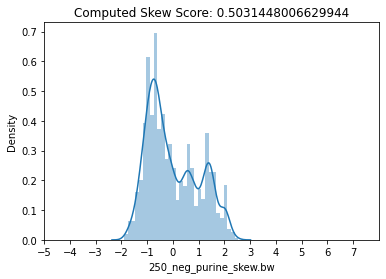

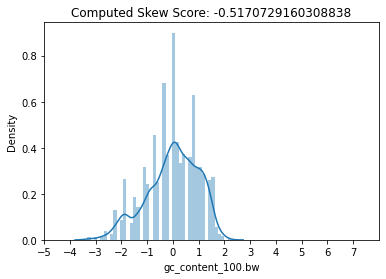

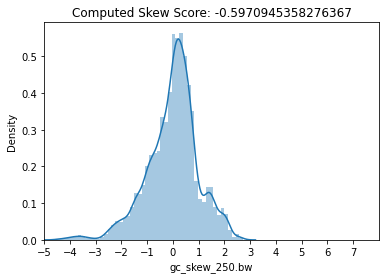

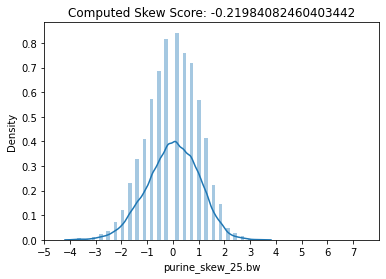

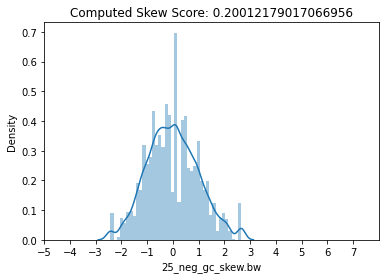

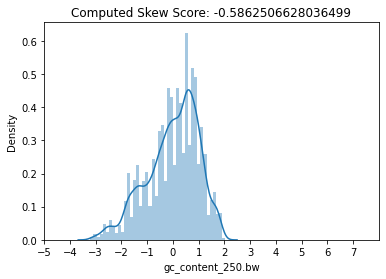

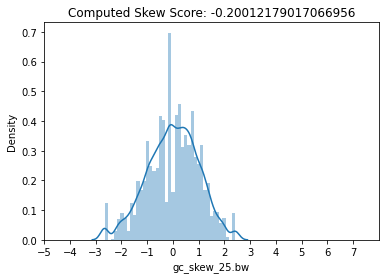

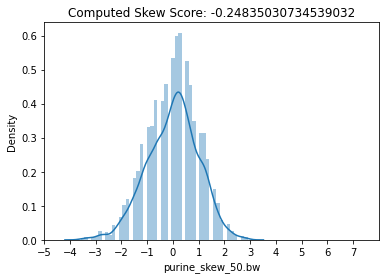

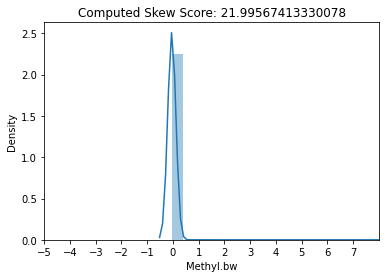

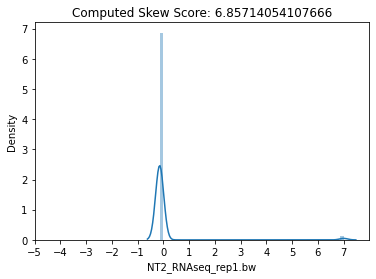

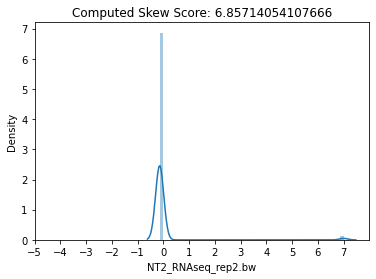

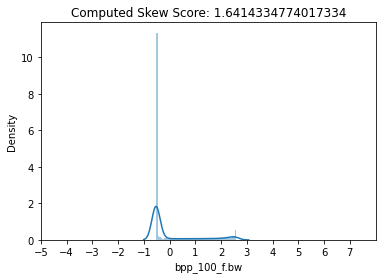

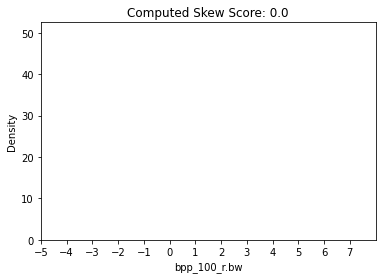

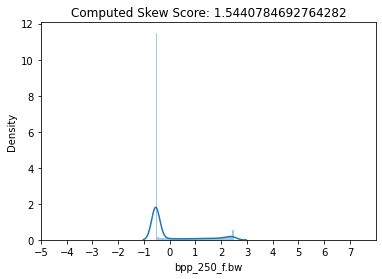

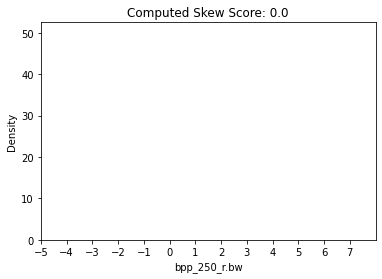

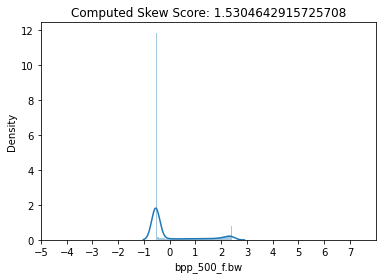

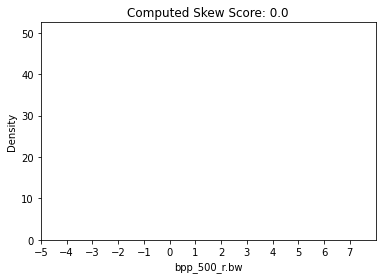

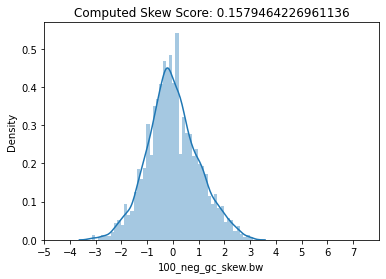

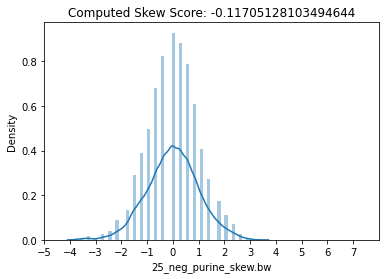

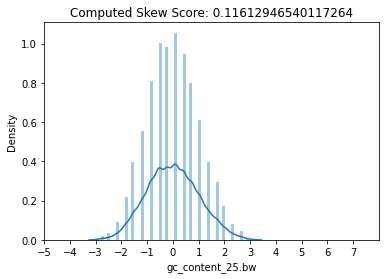

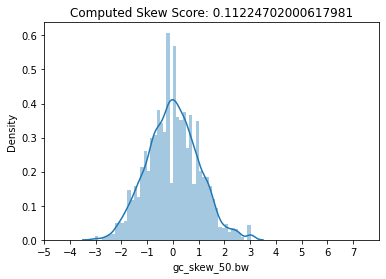

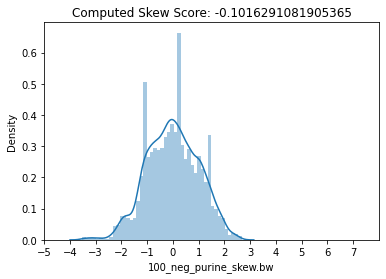

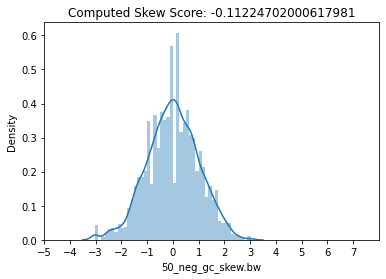

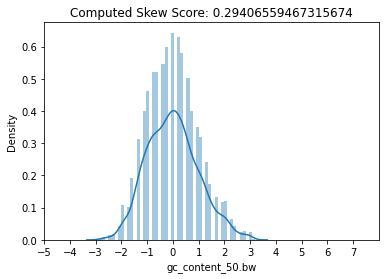

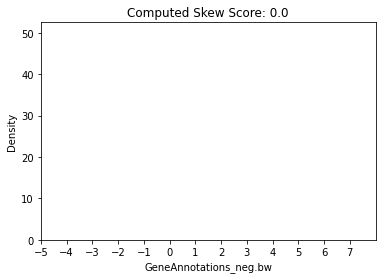

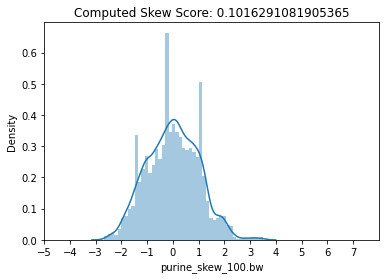

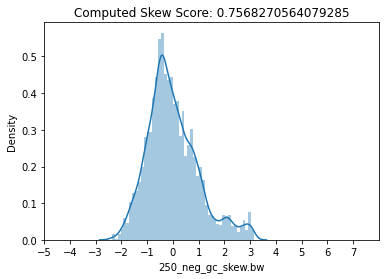

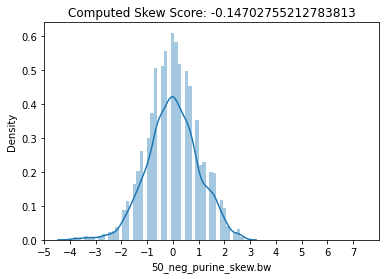

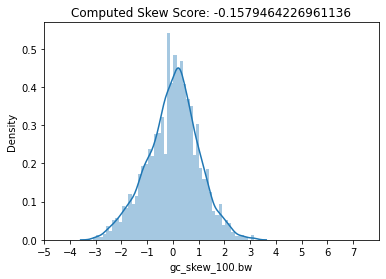

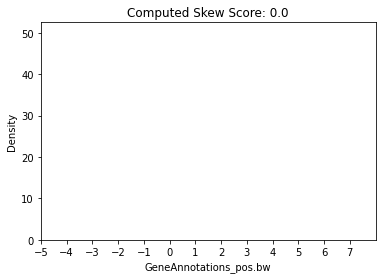

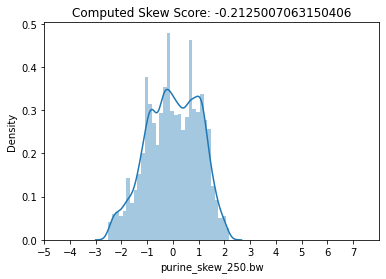

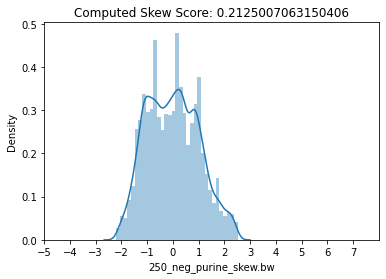

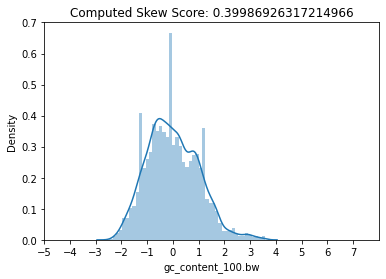

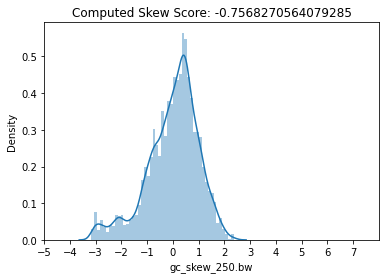

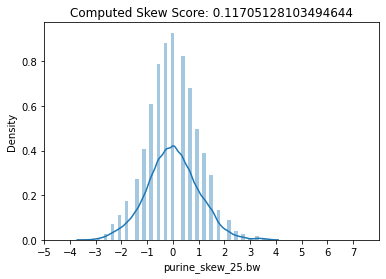

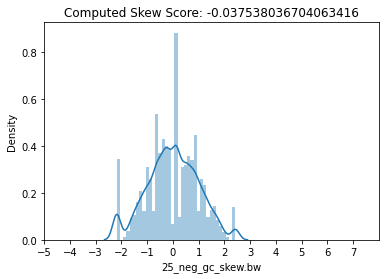

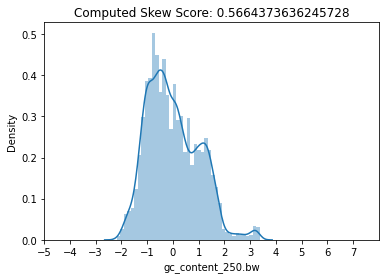

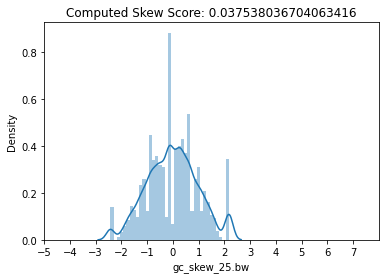

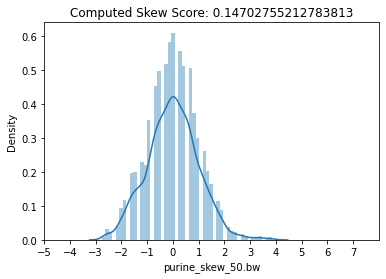

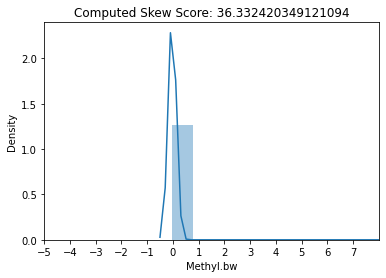

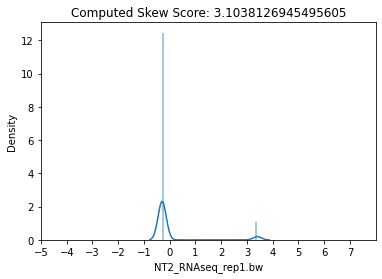

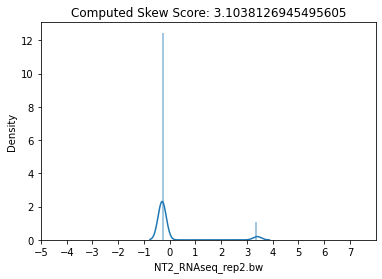

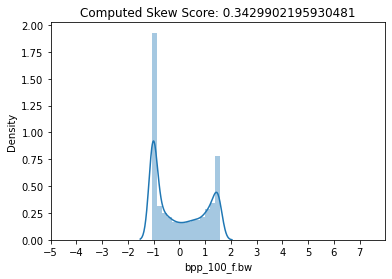

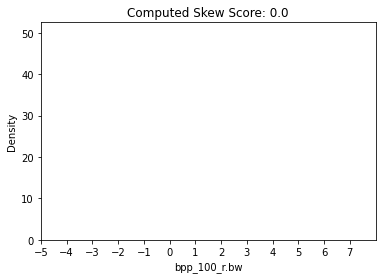

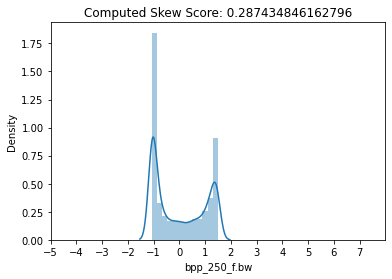

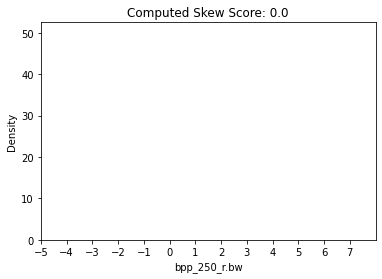

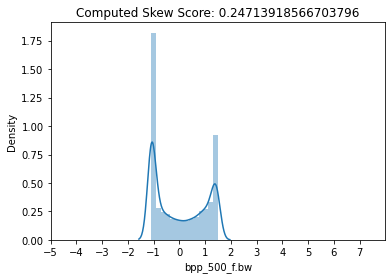

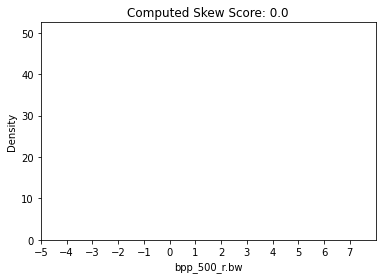

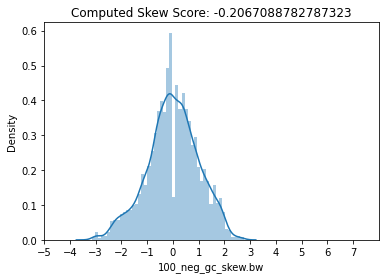

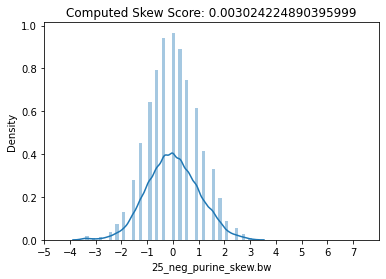

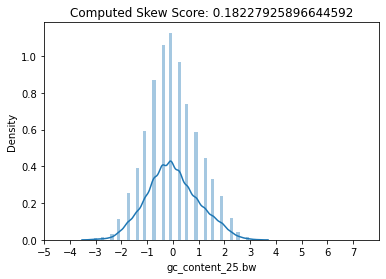

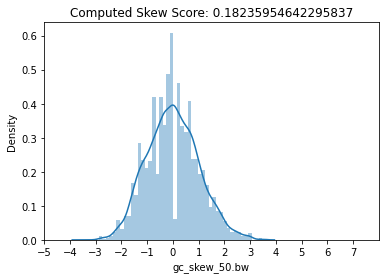

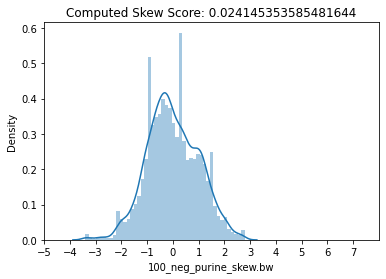

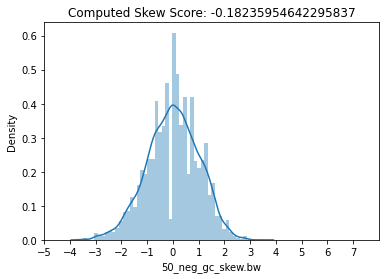

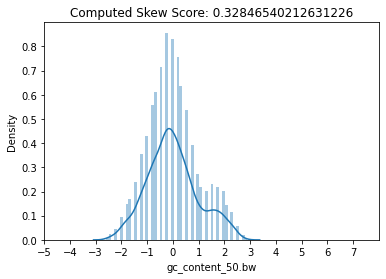

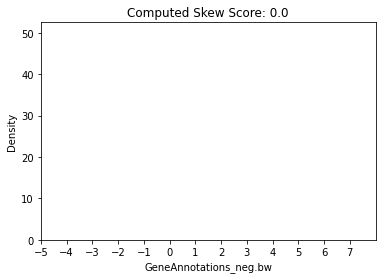

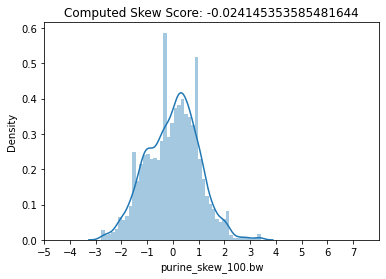

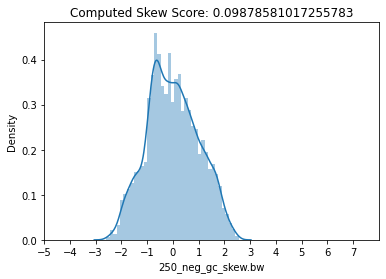

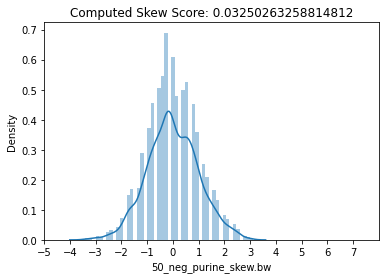

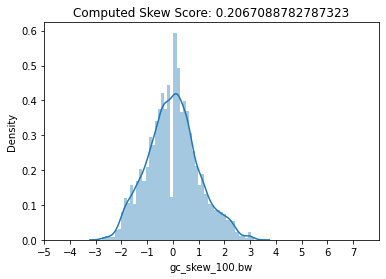

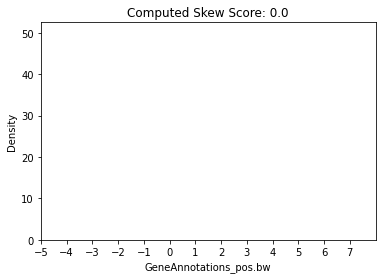

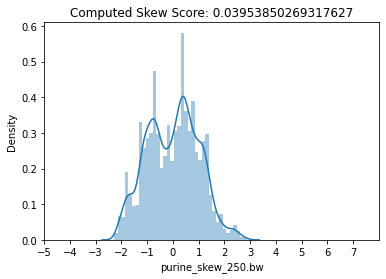

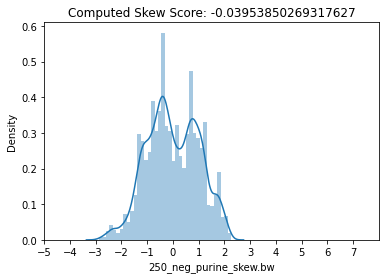

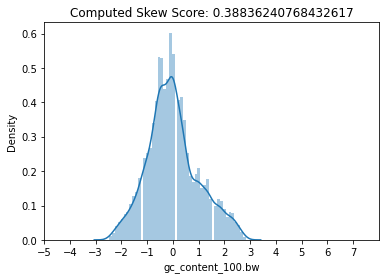

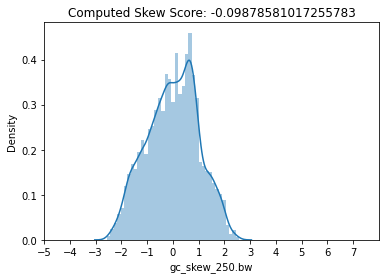

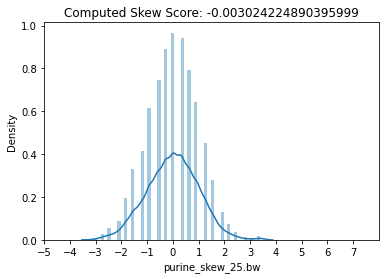

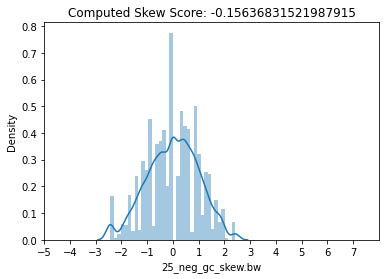

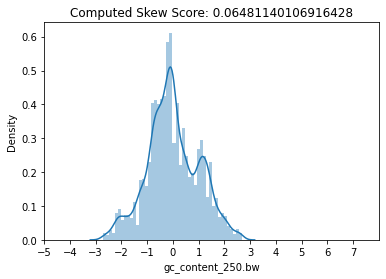

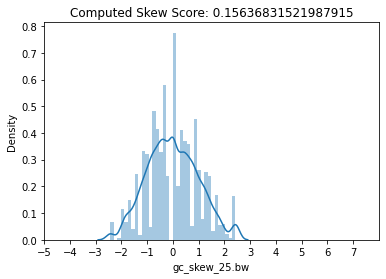

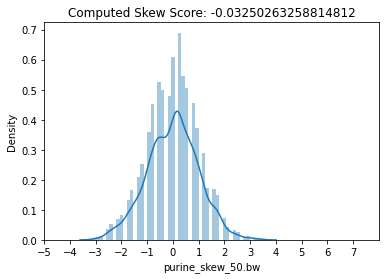

In [63]:
for i in range(int(len(intervals)/3)):
    # Get the interval
    interval = Interval(intervals[3*i], int(intervals[3*i+1]), int(intervals[3*i+2]))
    #print("Interval: ", interval)
    
    seq_width = 10000
    
    rows = []
    for file in files:
        seq_interval = resize_interval(deepcopy(interval), seq_width)
        channel = BigwigExtractor(file)
        rows += [channel([seq_interval])[0]]
    
    print(str(intervals[3*i] + ":" + intervals[3*i+1] + "," + intervals[3*i+2]))
    make_plots(rows, low=-5, high=8)
    #print(len(rows), len(rows[0]))